In [1]:
import pandas as pd
import numpy as np
import cPickle
import sys
sys.path.insert(0, '../../preprocess')
import vectorizer

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../data/files/test_cohen_dedup.csv')

nb_studies = len(df)
H = np.zeros((nb_studies, nb_studies))

cdnos = list(set(df.cdno))
for i in range(nb_studies) :
    H[i, df[df['cdno'] == df['cdno'][i]].index] = 1

H[np.arange(nb_studies), np.arange(nb_studies)] = 0

In [3]:
cohenvec = cPickle.load(open('../data/vectorizers/cohendata_dedup_5000.p', 'rb'))

In [5]:
from keras.models import load_model
model_pop = load_model('../store/weights/population_FriOct1314:26:462017_setup/0/0-loss.h5')
model_inter = load_model('../store/weights/intervention_FriOct1314:26:462017_setup/0/0-loss.h5')
model_outcome = load_model('../store/weights/outcome_FriOct1314:26:462017_setup/0/0-loss.h5')

In [6]:
models = {'pop' : model_pop, 'int' : model_inter, 'out' : model_outcome}

In [7]:
pools = {input : model.get_layer('pool') for input, model in models.items()}

In [8]:
inputs = {input : pool.inputs for input, pool in pools.items()}
import keras.backend as K
inputs = {input : x + [K.learning_phase()] for input, x in inputs.items()}

outputs = {input : pool.get_output_at(0) for input, pool in pools.items()}
embed_abstract = {input : K.function(inputs[input], [outputs[input]]) for input in pools.keys()}

In [9]:
X_cohen = cohenvec.X

In [10]:
embedds_dic = {input : embed_abstract[input]([X_cohen, 0])[0] for input in embed_abstract.keys()}

In [11]:
from sklearn.preprocessing import normalize
embedds_dic = {input : normalize(x, 'l2') for input, x in embedds_dic.items()}

In [12]:
embedd_filter = ['pop', 'int', 'out']
filter_embedds = {k: v for k, v in embedds_dic.items() if k in embedd_filter}

In [13]:
embedds = np.concatenate(filter_embedds.values(), axis=1)
embedds.shape

(1767, 2700)

In [14]:
scores = np.dot(embedds, embedds.T)
scores[np.arange(nb_studies), np.arange(nb_studies)] = -1000

In [15]:
K = 10
args = scores.argsort(axis=1)[:, -K:]
S = np.zeros((nb_studies, K))
for i in range(nb_studies) :
    for j in range(K) :
        S[i, j] = H[i, args[i, j]]
np.mean(S.sum(axis=1)/K)

0.79932088285229197

In [16]:
from sklearn.metrics import roc_auc_score
aucs = [0] * nb_studies
for i in range(nb_studies) :
    aucs[i] = roc_auc_score(H[i], scores[i])
print np.mean(aucs)
rocs = {}
for cd in cdnos :
    idxs = df[df.cdno == cd].index
    rocs[cd] = np.mean(np.array(aucs)[idxs])
print rocs

0.914957543647
{'NSAIDS_processed': 0.96275323543523617, 'ACEInhibitors_processed': 0.89849065634568226, 'SkeletalMuscleRelaxants_processed': 0.74151814890046808, 'Triptans_processed': 0.98705716938767885, 'OralHypoglycemics_processed': 0.98426599385186453, 'CalciumChannelBlockers_processed': 0.7965160525144358, 'BetaBlockers_processed': 0.8214681818136903, 'Estrogens_processed': 0.99058072105409389, 'ADHD_processed': 0.93376918084456983, 'Statins_processed': 0.8887356987756605, 'Antihistamines_processed': 0.80120156717095292, 'ProtonPumpInhibitors_processed': 0.94249238336160235, 'Opiods_processed': 0.97448274888076047, 'AtypicalAntipsychotics_processed': 0.99158599475255582}


In [17]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [18]:
tsne = TSNE().fit_transform(embedds)

In [19]:
tsne
labels = np.array([0] * nb_studies)
for i, cd in enumerate(cdnos) :
    idxs = df[df.cdno == cd].index
    labels[idxs] = i*2

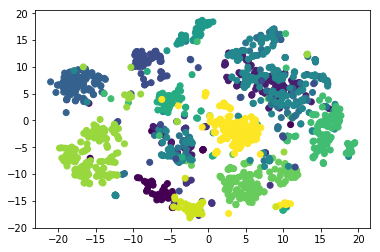

In [20]:
import matplotlib.pyplot as plt
plt.scatter(tsne[:, 0], tsne[:, 1],c=labels)
plt.show()